# 비디오 프레임 추출
## cv2 설치
`pip install opencv-contrib-python`

$\sum |I_1(i,j) - I_2(i+x,j+y) | $로 평가?

$ score =  \left( \sum_{i=x}^{(n-1)-x}  ( f(i+x)-f(i) )^2  \right) $ 최소로

$\frac {\partial score} {\partial x} =  0, \left(f(i+x)-f(i)\right)f'(i+x) = 0 $



In [5]:
import cv2
import numpy
import matplotlib.pyplot as plt

In [10]:
def FrameCapture(video):
    # the number of frame
    count = 0
    directory = "frame"
    
    # Path to video file 
    videoObject = cv2.VideoCapture(video) 
  
    print(videoObject.isOpened())
    # checks whether frames were extracted 
    success = 1
  
    while success: 
        # videoObject object calls read 
        success, image = videoObject.read() 

        if success != 1: break
        # Saves the frames 
        path = directory + '\\' + "frame%d.png" % count
        print(f"path:{path}")
        cv2.imwrite(path, image) 
  
        count += 1

In [11]:
FrameCapture('data\\video.MOV')

True
path:frame\frame0.png
path:frame\frame1.png
path:frame\frame2.png
path:frame\frame3.png
path:frame\frame4.png
path:frame\frame5.png
path:frame\frame6.png
path:frame\frame7.png
path:frame\frame8.png
path:frame\frame9.png
path:frame\frame10.png
path:frame\frame11.png
path:frame\frame12.png
path:frame\frame13.png
path:frame\frame14.png
path:frame\frame15.png
path:frame\frame16.png
path:frame\frame17.png
path:frame\frame18.png
path:frame\frame19.png
path:frame\frame20.png
path:frame\frame21.png
path:frame\frame22.png
path:frame\frame23.png
path:frame\frame24.png
path:frame\frame25.png
path:frame\frame26.png
path:frame\frame27.png
path:frame\frame28.png
path:frame\frame29.png
path:frame\frame30.png
path:frame\frame31.png
path:frame\frame32.png
path:frame\frame33.png
path:frame\frame34.png
path:frame\frame35.png
path:frame\frame36.png
path:frame\frame37.png
path:frame\frame38.png
path:frame\frame39.png
path:frame\frame40.png
path:frame\frame41.png
path:frame\frame42.png
path:frame\frame

## 이미지 들어간거 찾기
- [**Optical flow**](https://en.wikipedia.org/wiki/Optical_flow)라는 개념이 있으며, 얼마나 이미지가 변화하였는지를 나타냄
- 전체 이미지 비교 방법
- sub이미지로 나눠 비교하는 방법
- 특징점 추출방법
    - LMedS, RANSAC, SelMap [^1]


[^1] : [Zhaowei Li and David R. Selviah, Comparison of Image Alignment Algorithm, University College London](https://www.ee.ucl.ac.uk/lcs/previous/LCS2011/LCS1115.pdf)

In [59]:
i1 = cv2.imread("frame/frame0.png")
i2 = cv2.imread("frame/frame1.png")
i3 = cv2.imread("frame/frame2.png")
i4 = cv2.imread("frame/frame3.png")
i5 = cv2.imread("frame/frame4.png")
i6 = cv2.imread("frame/frame5.png")
i7 = cv2.imread("frame/frame6.png")

In [27]:
cv2.imshow("im1",i1)
cv2.imshow("im2",i5)
cv2.waitKey(0)

-1

In [43]:
cv2.destroyAllWindows()

In [ ]:
img = i1-i2
cv2.imshow("img",img)
cv2.waitKey(0)

In [141]:
cnt = 0
def parallelMovement(i1,i2, r):
    global cnt

    px, py = 0 ,0 

    h, w, = i1.shape
    # h, w, _ = i1.shape
    xl = 4
    yl = 4

    xrange = range(-xl+px, xl+1+px)
    yrange = range(-yl+py, yl+1+py)

    score =  numpy.zeros((xl*2+1,yl*2+1),dtype=int)

    for xh in xrange:
        for yh in yrange:
            i_sum = 0
            
            t1 = i1[max(0,yh):h+min(0,yh) , max(0,xh):w+min(0,xh) ]
            t2 = i2[max(0,-yh):h-max(0,yh), max(0,-xh):w-max(0,xh)]
            # print(t1.shape, t2.shape)
            img = t1-t2

            # print('img',img.shape)
            
            score[xh+xl,yh+yl] = sum(sum(numpy.abs(img.astype('int8').astype('int32'))))
            # score[xh+xl,yh+yl] = sum(sum(sum(numpy.abs(img.astype('int8').astype('int32')))))
            # print(score)


    score = score/ (w-xl)/(h-yl)
    # score = 1/(score*score)
    print(score.round(4))

    ## 시각화
    x,y = numpy.meshgrid(
        numpy.array(xrange),
        numpy.array(yrange)
    )

    # fig = plt.figure()
    # ax = fig.gca(projection='3d')
    # ax.plot_surface(x,y,score, cmap="BuPu")
    # plt.show()

    plt.grid(True)
    d = score.reshape((xl*2+1)*(yl*2+1))

    mylevels = numpy.linspace(min(d),max(d),15)
    if min(d) < max(d):
        plt.subplot(r,r,cnt)
        ourplot = plt.contourf(x,y,score,levels=mylevels,) #cmap="coolwarm"

    sum_xy = lambda x,y : sum([(xh**x)*(yh**y) for xh in xrange for yh in yrange])
    view_xy = lambda x,y : sum([(xh**x)*(yh**y)*score[yh+yl, xh+xl] for xh in xrange for yh in yrange])

    # x,y = 0,0

    diff = [(2,0),(1,1),(0,2),(1,0),(0,1),(0,0)]

    A = numpy.array([[sum_xy(x+i,y+j) for x,y in diff] for i,j in diff])
    Y = numpy.array([[view_xy(x,y)] for x,y in diff])
    invA = numpy.linalg.inv(A)

    X = invA@Y
    a,b,c,d,e,f =  X.reshape(6)
    # -numpy.linalg.inv(numpy.array([[2*a,b],[b,2*c]]))@numpy.array([[d],[e]])
    minX, minY = -(b*e-2*c*d)/(b*b-4*a*c), -(b*d-2*a*e)/(b*b-4*a*c)
    return minX, minY




In [ ]:
s = (score).reshape((xl*2+1)*(yl*2+1)).sum()
[
(x*score).reshape((xl*2+1)*(yl*2+1)).sum()/s,
(y*score).reshape((xl*2+1)*(yl*2+1)).sum()/s
]

[0.025734175781299724, 0.6276613915803442]

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(nan, nan) (100, 100) (100, 100) 3
[[0.1285 0.1274 0.1207 0.1207 0.1243 0.1229 0.1247 0.126  0.1273]
 [0.1284 0.1286 0.1227 0.1184 0.1251 0.1254 0.1241 0.127  0.13  ]
 [0.1266 0.1284 0.1264 0.1164 0.119  0.1259 0.1246 0.127  0.1298]
 [0.1281 0.1281 0.1286 0.1175 0.1086 0.123  0.122  0.1224 0.128 ]
 [0.1277 0.1268 0.1292 0.1203 0.0945 0.1272 0.1259 0.1202 0.1293]
 [0.1213 0.1165 0.12   0.1094 0.0562 0.114  0.1214 0.116  0.1251]
 [0.1254 0.1183 0.123  0.1185 0.0699 0.1086 0.1179 0.1145 0.1199]
 [0.1278 0.1224 0.1272 0.1272 0.1037 0.1175 0.1279 0.1238 0.1268]
 [0.1301 0.1234 0.1232 0.126  0.1127 0.1128 0.1254 0.1246 0.1274]]
(0.11900748232701958, 1.1784722572070656) (100, 100) (100, 100) 3
[[0.0037 0.004  0.0043 0.0051 0.0

C:\Users\User\AppData\Local\Temp\ipykernel_10080\2335730025.py:70: RuntimeWarning: invalid value encountered in double_scalars
  minX, minY = -(b*e-2*c*d)/(b*b-4*a*c), -(b*d-2*a*e)/(b*b-4*a*c)


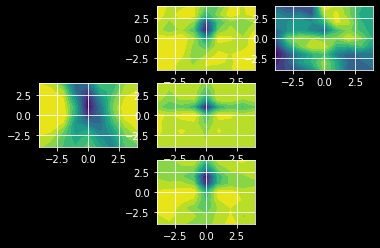

In [149]:
h, w, _ = i1.shape
cnt = 1
# src1, src2 = cv2.cvtColor(i1, cv2.COLOR_RGB2GRAY), cv2.cvtColor(i5, cv2.COLOR_RGB2GRAY)
src1, src2 = cv2.Canny(i1, 0, 255), cv2.Canny(i5, 0, 255)
#gray = cv2.cvtColor(i1, cv2.COLOR_RGB2GRAY)
edge = 100
r = 3

for j in range(w//(r*2),w,w//r):
    for i in range(h//(r*2),h,h//r):
        pi1,pi2 = src1[i:i+edge, j:j+edge,],  src2[i:i+edge, j:j+edge,]
        
        k = parallelMovement(pi1,pi2,r)
        cnt += 1
        print(k, pi1.shape,pi2.shape,r)

## 그냥: 3.5초
# canny: 2.1초
# 크기+줄이기 0.7초
# 회색+크기 줄이기: 1.9

# 목표 1/60=0.01=10ms 

In [108]:
# gray = cv2.cvtColor(i1, cv2.COLOR_RGB2GRAY)
# sobel = cv2.Sobel(gray, cv2.CV_8U, 1, 0, 3)
# laplacian = cv2.Laplacian(gray, cv2.CV_8U, ksize=3)
src = i1
w,h,c = src.shape
f = 4
# dst = cv2.pyrUp(src, dstsize=(w // f, h // f), borderType=cv2.BORDER_DEFAULT)
# dst = cv2.pyrDown(cv2.pyrDown(src))
# cv2.imshow('dst',src)
canny = cv2.Canny(src, 0, 255)
cv2.imshow("canny", canny)
cv2.waitKey()


-1

In [127]:

src2 = canny.copy()
h,w = src2.shape
for i in range(w//6,w,w//3):
    for j in range(h//6,h,h//3):
        src2 = cv2.rectangle(src2, (i, j), (i+edge, j+edge), (255, 0, 0), 5, cv2.LINE_8)
# plt.plot(gray)
cv2.imshow("src2", cv2.pyrDown(cv2.pyrDown(src2)))
cv2.waitKey()

-1

In [61]:
a = numpy.array(range(9)).reshape((3,3))
a**2
cv2.destroyAllWindows()

In [103]:
src2.shape

(1440, 1920)

In [ ]:
numpy.array([[a*x*x + b*x*y + c*y*y + d*x + e*y + f for x in xrange] for y in yrange]).round(2)

array([[46.35, 40.65, 36.48, 33.84, 32.74, 33.17, 35.14, 38.64, 43.68],
       [42.2 , 36.52, 32.38, 29.77, 28.69, 29.15, 31.14, 34.67, 39.73],
       [38.97, 33.32, 29.21, 26.63, 25.58, 26.07, 28.09, 31.64, 36.73],
       [36.69, 31.07, 26.98, 24.42, 23.4 , 23.92, 25.96, 29.55, 34.66],
       [35.34, 29.75, 25.69, 23.16, 22.16, 22.71, 24.78, 28.39, 33.53],
       [34.93, 29.36, 25.33, 22.83, 21.86, 22.43, 24.53, 28.17, 33.34],
       [35.46, 29.92, 25.91, 23.44, 22.5 , 23.1 , 25.22, 28.89, 34.08],
       [36.93, 31.41, 27.43, 24.99, 24.07, 24.7 , 26.85, 30.54, 35.77],
       [39.33, 33.84, 29.89, 27.47, 26.59, 27.23, 29.42, 33.14, 38.39]])

In [ ]:
[[for xh in range(-xl, xl+1)] for yh in range(-yl, yl+1)]

(0.4703768436590926, 0.014868623858982999)

In [ ]:
k= numpy.array(range(3**2)).reshape((3,3))
k

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [ ]:
w, h

(1440, 1920)

In [ ]:
sum(numpy.abs(img.astype('int8')))

array([[ 108,  -20,  -54],
       [  70,  -16,  -68],
       [  55,  -37,  -93],
       ...,
       [  33,   71, -116],
       [ -46, -115,   23],
       [  22,   -2,   44]], dtype=int8)

In [ ]:
(score/ (w-xl)/(h-yl)).round(2)

array([[38.28, 37.21, 35.72, 33.77, 31.94, 32.44, 34.07, 35.54, 36.56],
       [36.39, 35.06, 33.17, 30.72, 28.36, 29.06, 31.2 , 33.16, 34.6 ],
       [33.67, 31.87, 29.34, 25.97, 22.69, 23.74, 26.87, 29.74, 31.88],
       [30.45, 27.97, 24.38, 19.37, 14.14, 16.07, 21.3 , 25.7 , 28.82],
       [28.57, 25.49, 20.89, 14.06,  5.36,  9.55, 17.38, 23.02, 26.78],
       [30.35, 27.78, 24.1 , 19.19, 14.34, 16.63, 21.85, 26.06, 28.99],
       [32.96, 31.17, 28.68, 25.55, 22.68, 24.15, 27.53, 30.43, 32.5 ],
       [35.31, 34.1 , 32.36, 30.19, 28.21, 29.29, 31.76, 33.9 , 35.42],
       [37.  , 36.14, 34.86, 33.19, 31.7 , 32.54, 34.53, 36.22, 37.42]])